In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import datacleaning
import itertools
from nltk.probability import FreqDist
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
def do_centrality(G: nx.Graph):
    deg = pd.DataFrame(nx.degree_centrality(G).items(), columns=['Id', 'degree_centrality'])
    # eig = pd.DataFrame(nx.eigenvector_centrality_numpy(G, weight="Weight").items(), columns=['Id', 'eigenvector_centrality'])
    merged = pd.merge(data[['Id','title']], deg, on = "Id")
    return merged

data = pd.read_csv("data_small.csv", converters={"ingredient_words": literal_eval,"instruction_words": literal_eval})
data = data.rename(columns={"Unnamed: 0":"Id"})

In [3]:
graph_instruction = nx.read_gexf("recipe_instruction_small.gexf")
graph_ingredient = nx.read_gexf("recipe_ingredient_small.gexf")

graph_recipe_instruction_allwords = nx.read_gexf("recipe_instruction_nofilter.gexf")
graph_recipe_ingredient_allwords = nx.read_gexf("recipe_ingredient_nofilter.gexf")

graph_recipe_instruction_tfidf = nx.read_gexf("recipe_instruction_tfidf.gexf")
graph_recipe_ingredient_tfidf = nx.read_gexf("recipe_ingredient_tfidf.gexf")

graph_recipe_instruction_ranked_tfidf = nx.read_gexf("recipe_instruction_ranked_tfidf.gexf")
graph_recipe_ingredient_ranked_tfidf = nx.read_gexf("recipe_ingredient_ranked_tfidf.gexf")

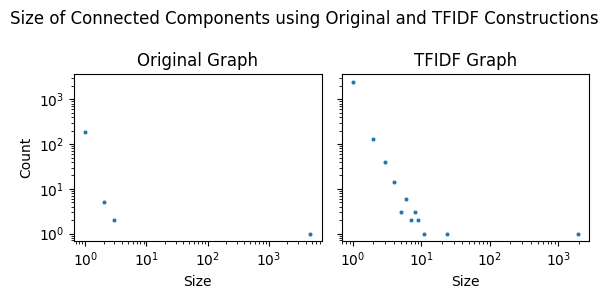

In [4]:
def count_components(G: nx.graph):
    graph_CCs = sorted(nx.connected_components(G), key=len, reverse=True)

    graph_CCs_subgraphs = [G.subgraph(c).copy() for c in graph_CCs]

    lens = [len(g) for g in graph_CCs_subgraphs]
    s, count = np.unique(np.sort(lens), return_counts=True)
    return np.asarray((s,count))

def plot_components(data, axes):
    a = sns.scatterplot(x = data[0], y = data[1], ax=axes, s=10)
    a.set_xscale('log')
    a.set_yscale('log')

fig, axes = plt.subplots(1,2, figsize= (6,3), sharey=True)
plot_components(count_components(graph_ingredient), axes=axes[0])
plot_components(count_components(graph_recipe_ingredient_tfidf), axes=axes[1])
axes[0].set_title("Original Graph")
axes[1].set_title("TFIDF Graph")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Size")
axes[1].set_xlabel("Size")
fig.suptitle("Size of Connected Components using Original and TFIDF Constructions")

fig.tight_layout()
plt.savefig('figs/original_tfidf_components.pdf')

In [5]:
# (do_centrality(graph_ingredient)).sort_values(by = 'degree_centrality', ascending = False)

In [6]:
# (do_centrality(graph_instruction)).sort_values(by = 'degree_centrality', ascending = False)

In [7]:
# (do_centrality(graph_recipe_ingredient_tfidf)).sort_values(by = 'degree_centrality', ascending = False)


In [8]:
graphs = [graph_ingredient, graph_instruction, graph_recipe_ingredient_allwords, graph_recipe_instruction_allwords, graph_recipe_ingredient_tfidf, graph_recipe_instruction_tfidf, graph_recipe_ingredient_ranked_tfidf, graph_recipe_instruction_ranked_tfidf]

In [9]:
graph_pairs = itertools.combinations(graphs, r=2)

In [10]:
import scipy
names = ["Original Ingredient", "Original Instruction", "All Ingredient Words", "All Instruction Words", "TFIDF Ingredient", "TFIDF Instruction", "Ranked TFIDF Ingredient", "Ranked TFIDF Instruction"]
graph_distance = pd.DataFrame(np.zeros(shape = (len(graphs), len(graphs))), columns=names)
graph_distance.insert(0, 'i', names)
graph_distance = graph_distance.set_index('i')
for i in range(len(graphs)):
    for j in range(len(graphs)):
        if i>j:
            graph_distance.iloc[i,j] = scipy.sparse.linalg.norm(nx.adjacency_matrix(graphs[i]) - nx.adjacency_matrix(graphs[j]))

#     for j in range(len(graphs)):
#         if i<j:
#             graph_distance[i,j] = 1
            # graph_distance[i,j] = 

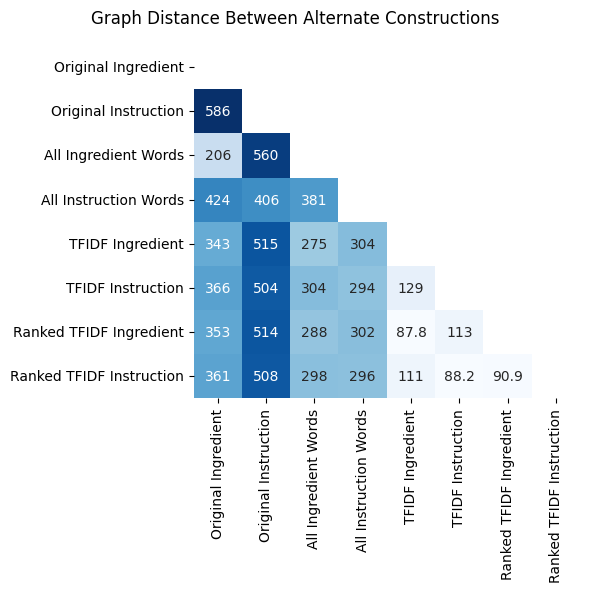

In [11]:
fig, ax = plt.subplots(1,1, figsize= (6,6), sharey=True)
a=sns.heatmap(graph_distance, annot=True, cmap="Blues", ax=ax, cbar = False, fmt='.3g', mask=(graph_distance==0))
a.set_ylabel("")
fig.suptitle("Graph Distance Between Alternate Constructions")
fig.tight_layout()
plt.savefig('figs/all_graphdistance.pdf')



In [12]:
def do_centralities(G: nx.Graph):
    deg = pd.DataFrame(nx.degree_centrality(G).items(), columns=['Id', 'degree_centrality'])
    pagerank = pd.DataFrame(nx.pagerank(G, weight="Weight").items(), columns=['Id', 'pagerank_centrality'])
    betweenness = pd.DataFrame(nx.betweenness_centrality(G, weight="Weight").items(), columns=['Id', 'betweenness_centrality'])
    merged = pd.merge(data, deg, on = "Id")
    merged = pd.merge(merged, pagerank, on = "Id")
    merged = pd.merge(merged, betweenness, on = "Id")
    return merged

In [13]:
# instruction_ranked_tfidf_cent = do_centralities(graph_recipe_instruction_ranked_tfidf)

In [14]:
instructions_idf = pd.read_csv("instructions_idf.csv")
ingredients_idf = pd.read_csv("ingredients_idf.csv")

instructions_idf = instructions_idf.drop(columns= 'Unnamed: 0')
ingredients_idf = ingredients_idf.drop(columns= 'Unnamed: 0')

def calculate_idf_sum(instructions, idfs):
    instruction_words = instructions.split()
    wordset = set(idfs['word'])
    idfs = idfs.set_index('word')
    sum = 0
    for word in instruction_words:
        if word in wordset: 
            sum = sum + idfs.loc[word]
    return(sum) 

calculate_idf_sum("preheat oven degrees", instructions_idf)

def all_idf_sum(dat, idfs):
    dat['sum_idf'] = dat.apply(lambda l: calculate_idf_sum(l['clean_instructions_masked'], idfs=idfs), axis=1)
    return dat

In [15]:
# instructions_idf = pd.concat([ingredients_idf,instructions_idf])

# instruction_ranked_tfidf_cent['sum_idf'] = instruction_ranked_tfidf_cent['clean_instructions_masked']

# instruction_ranked_tfidf_cent = all_idf_sum(instruction_ranked_tfidf_cent, instructions_idf)

In [16]:
# fig, axes = plt.subplots(1,1, figsize= (6,6))
# sns.scatterplot(x=instruction_ranked_tfidf_cent['betweenness_centrality'], y=instruction_ranked_tfidf_cent['sum_idf'], size = .1, alpha = .1)
# fig.tight_layout()

In [17]:
instruction_ranked_tfidf_cent = pd.read_csv('instruction_ranked_tfidf_cent.csv', converters={"ingredient_words": literal_eval,"instruction_words": literal_eval})

In [18]:
instruction_ranked_tfidf_cent.to_csv('instruction_ranked_tfidf_cent.csv')
instruction_ranked_tfidf_cent.sort_values(by='betweenness_centrality', ascending=False).head(10)

,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,title,...,clean_ingredients,clean_instructions,clean_instructions_masked,ingredient_words,instruction_words,index,degree_centrality,pagerank_centrality,betweenness_centrality,sum_idf
3474,3474,3474,3474,3474,3474,3474,3474,3474,Ug6Rt5Zkk7kqV6XT15TPCxHICZFT3/W,Parmesan Basil Tomato Soup,...,vegetable oil finely chopped onion minced garl...,heat vegetable oil saucepan mediumhigh heat co...,heat saucepan mediumhigh heat cook stir tender...,"[vegetable, oil, finely, chopped, onion, mince...","[heat, saucepan, mediumhigh, heat, cook, stir,...",Ug6Rt5Zkk7kqV6XT15TPCxHICZFT3/W,0.009602,0.002275,0.070661,39.296091
586,586,586,586,586,586,586,586,586,gjbjEVVvs/bCyogg5YNHeoRt9ZY1.j2,Pork Picadillo,...,olive oil onion diced cloves garlic crushed gr...,heat olive oil large skillet medium heat cook ...,heat large skillet medium heat cook stir tende...,"[olive, oil, onion, diced, cloves, garlic, cru...","[heat, large, skillet, medium, heat, cook, sti...",gjbjEVVvs/bCyogg5YNHeoRt9ZY1.j2,0.006001,0.001437,0.047740,86.394946
4850,4850,4850,4850,4850,4850,4850,4850,4850,AjyqfITWPPoborWgRWTpqpn8hskX6V2,Chili Casserole,...,macaroni cooked chili beans sweet corn drained...,preheat oven degrees degrees large bowl combin...,preheat oven degrees degrees large bowl combin...,"[macaroni, cooked, chili, beans, sweet, corn, ...","[preheat, oven, degrees, degrees, large, bowl,...",AjyqfITWPPoborWgRWTpqpn8hskX6V2,0.004001,0.000990,0.043518,37.528161
2933,2933,2933,2933,2933,2933,2933,2933,2933,n/Tkhv693Sl69p7Gpzkd2d1DaW0c1pi,Millet Mung Bean Main Dish,...,water divided dried mung beans millet vegetabl...,bring water mung beans boil pot cover reduce h...,bring boil pot cover reduce heat mediumlow sim...,"[water, divided, dried, mung, beans, millet, v...","[bring, boil, pot, cover, reduce, heat, medium...",n/Tkhv693Sl69p7Gpzkd2d1DaW0c1pi,0.003401,0.000797,0.037250,97.307047
4567,4567,4567,4567,4567,4567,4567,4567,4567,osOWZ7F29BABvQJvKGFne7h7B0GcLM2,Honey Cornbread,...,allpurpose flour yellow cornmeal white sugar b...,preheat oven degrees degrees lightly grease x ...,preheat oven degrees degrees grease x pan larg...,"[allpurpose, flour, yellow, cornmeal, white, s...","[preheat, oven, degrees, degrees, grease, x, p...",osOWZ7F29BABvQJvKGFne7h7B0GcLM2,0.003601,0.000919,0.035274,81.261066
274,274,274,274,274,274,274,274,274,2CezPqmLlRtrlvMt6XzzXqSk3sd1.I.,Sour Cream Chicken,...,sour cream condensed cream chicken soup white ...,preheat oven degrees degrees combine sour crea...,preheat oven degrees degrees combine mix well ...,"[sour, cream, condensed, cream, chicken, soup,...","[preheat, oven, degrees, degrees, combine, mix...",2CezPqmLlRtrlvMt6XzzXqSk3sd1.I.,0.004001,0.000985,0.035155,34.762203
3701,3701,3701,3701,3701,3701,3701,3701,3701,OHGzldiGToERtjNpncwROa5AroDcMvS,"Indian-Style Rice with Cashews, Raisins and Tu...",...,vegetable oil basmati rice coconut milk cans c...,heat oil large pot mediumhigh heat stir rice c...,heat large pot mediumhigh heat stir cook minut...,"[vegetable, oil, basmati, rice, coconut, milk,...","[heat, large, pot, mediumhigh, heat, stir, coo...",OHGzldiGToERtjNpncwROa5AroDcMvS,0.004801,0.001124,0.034420,38.574166
1681,1681,1681,1681,1681,1681,1681,1681,1681,4XcOu9d85WM.So51E6mx8H2g4hN9egu,Potato Chip Chicken Casserole,...,chopped cooked chicken meat cooked white rice ...,preheat oven degrees degrees large bowl combin...,preheat oven degrees degrees large bowl combin...,"[chopped, cooked, chicken, meat, cooked, white...","[preheat, oven, degrees, degrees, large, bowl,...",4XcOu9d85WM.So51E6mx8H2g4hN9egu,0.002601,0.000643,0.031751,50.213064
1488,1488,1488,1488,1488,1488,1488,1488,1488,T1xROF1DYf4GjWkpXosiw6qS6uvV51O,Mayonnaise Cake III,...,hot water mayonnaise vanilla extract white sug...,preheat oven degrees degrees grease flour x pa...,preheat oven degrees degrees grease x pan sift...,"[hot, water, mayonnaise, vanilla, extract, 

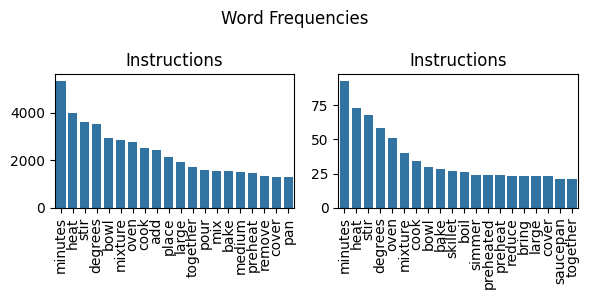

In [61]:
import statistics
stddv = statistics.stdev(instruction_ranked_tfidf_cent['betweenness_centrality'])
mean = statistics.mean(instruction_ranked_tfidf_cent['betweenness_centrality'])
# sns.histplot(data=instruction_ranked_tfidf_cent, x='betweenness_centrality')

A = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] < mean]
A = FreqDist(list(itertools.chain.from_iterable(A["instruction_words"])))
B = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] > mean + 4*stddv]
B = FreqDist(list(itertools.chain.from_iterable(B["instruction_words"])))

inst1 = ((pd.DataFrame({a:[b] for a, b in [item for item in A.items()]})).T.reset_index())
inst2 = ((pd.DataFrame({a:[b] for a, b in [item for item in B.items()]})).T.reset_index())

inst1 = inst1.sort_values(by=0, ascending=False).head(20)
inst2 = inst2.sort_values(by=0, ascending=False).head(20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

a = sns.barplot(y=inst1[0], x=inst1['index'], ax = axes[0])
a.tick_params(axis='x', rotation=90)
a.set_xlabel("")
a.set_ylabel("")
a.set_title("Instructions")

b = sns.barplot(y=inst2[0], x=inst2['index'], ax = axes[1])
b.tick_params(axis='x', rotation=90)
b.set_xlabel("")
b.set_ylabel("")
b.set_title("Instructions")

fig.suptitle("Word Frequencies")
fig.tight_layout()

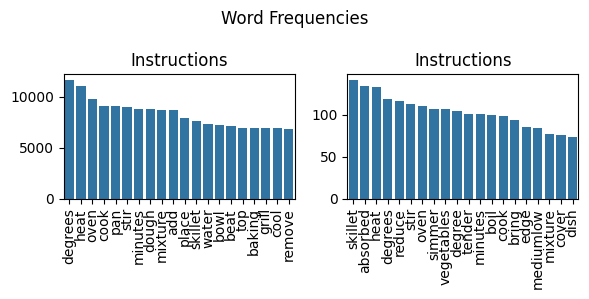

In [85]:
import statistics
stddv = statistics.stdev(instruction_ranked_tfidf_cent['betweenness_centrality'])
mean = statistics.mean(instruction_ranked_tfidf_cent['betweenness_centrality'])
# sns.histplot(data=instruction_ranked_tfidf_cent, x='betweenness_centrality')

A = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] < mean]
A = FreqDist(list(itertools.chain.from_iterable(A["instruction_words"])))
B = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] > mean + 5*stddv]
B = FreqDist(list(itertools.chain.from_iterable(B["instruction_words"])))

inst1 = ((pd.DataFrame({a:[b] for a, b in [item for item in A.items()]})).T.reset_index()).rename(columns={'index':"word",0:'count'})
inst2 = ((pd.DataFrame({a:[b] for a, b in [item for item in B.items()]})).T.reset_index()).rename(columns={'index':"word",0:'count'})

inst1 = inst1.merge(instructions_idf, on = 'word')
inst1['weighted_frequency'] = inst1['count'] * (inst1['weight']**2)
inst2 = inst2.merge(instructions_idf, on = 'word')
inst2['weighted_frequency'] = inst2['count'] * (inst2['weight']**2)

inst1 = inst1.sort_values(by='weighted_frequency', ascending=False).head(20)
inst2 = inst2.sort_values(by='weighted_frequency', ascending=False).head(20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

a = sns.barplot(y=inst1['weighted_frequency'], x=inst1['word'], ax = axes[0])
a.tick_params(axis='x', rotation=90)
a.set_xlabel("")
a.set_ylabel("")
a.set_title("Instructions")

b = sns.barplot(y=inst2['weighted_frequency'], x=inst2['word'], ax = axes[1])
b.tick_params(axis='x', rotation=90)
b.set_xlabel("")
b.set_ylabel("")
b.set_title("Instructions")

fig.suptitle("Word Frequencies")
fig.tight_layout()

In [34]:
inst_communities = nx.community.louvain_communities(graph_recipe_instruction_ranked_tfidf, resolution=1,seed=2024)
ingr_communities = nx.community.louvain_communities(graph_recipe_ingredient_ranked_tfidf, resolution=1,seed=2024)
# for level in inst_communities:
#     print(sorted([len(com) for com in level])[::-1])

In [35]:
inst_communities = sorted(inst_communities, key=len)[::-1]
ingr_communities = sorted(ingr_communities, key=len)[::-1]

In [26]:
([len(community) for community in inst_communities])

[425,
 377,
 366,
 349,
 276,
 199,
 157,
 148,
 145,
 142,
 137,
 129,
 127,
 116,
 113,
 107,
 107,
 100,
 94,
 93,
 90,
 86,
 85,
 84,
 81,
 81,
 73,
 61,
 60,
 60,
 59,
 59,
 56,
 52,
 40,
 40,
 40,
 38,
 34,
 31,
 23,
 21,
 15,
 7,
 6,
 5,
 3,
 3]

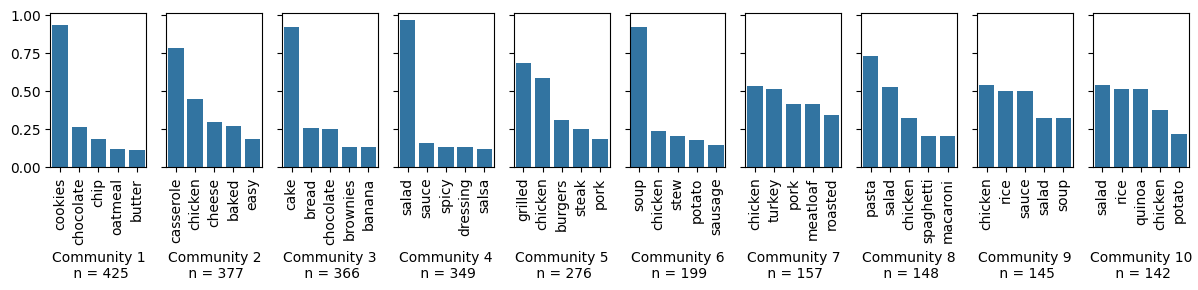

In [28]:
# datacleaning.data_for_nodes(inst_communities[0])
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
n=10
k=5
def title_dist_for_nodes(nodes, axes):
    dats = datacleaning.data_for_nodes(nodes)
    dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    dats['title_words'] = dats['title_words'].str.lower()
    dats['title_words'] = dats['title_words'].str.split()
    
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(sorted(FreqDist(title_words).most_common(k), key=lambda x: x[1], reverse=True))
    sns.barplot(x=title_freqs[0], y=title_freqs[1]/np.linalg.norm(title_freqs[1]), ax= axes)
    return title_words


fig, ax = plt.subplots(1,n, figsize= (12,3), sharey=True)
i = 1
plt_i = 0
for community in inst_communities:
    if len(community) < 100:
        i = i + 1
        continue
    if plt_i >= n:
        break

    title_dist_for_nodes(inst_communities[i], ax[plt_i])
    ax[plt_i].tick_params('x', labelrotation=90)
    ax[plt_i].set_xlabel("Community " + str(i) + "\n n = " + str(len(community)))
    ax[plt_i].set_ylabel("")

    plt_i = plt_i + 1
    i = i + 1

fig.align_xlabels()
fig.tight_layout()



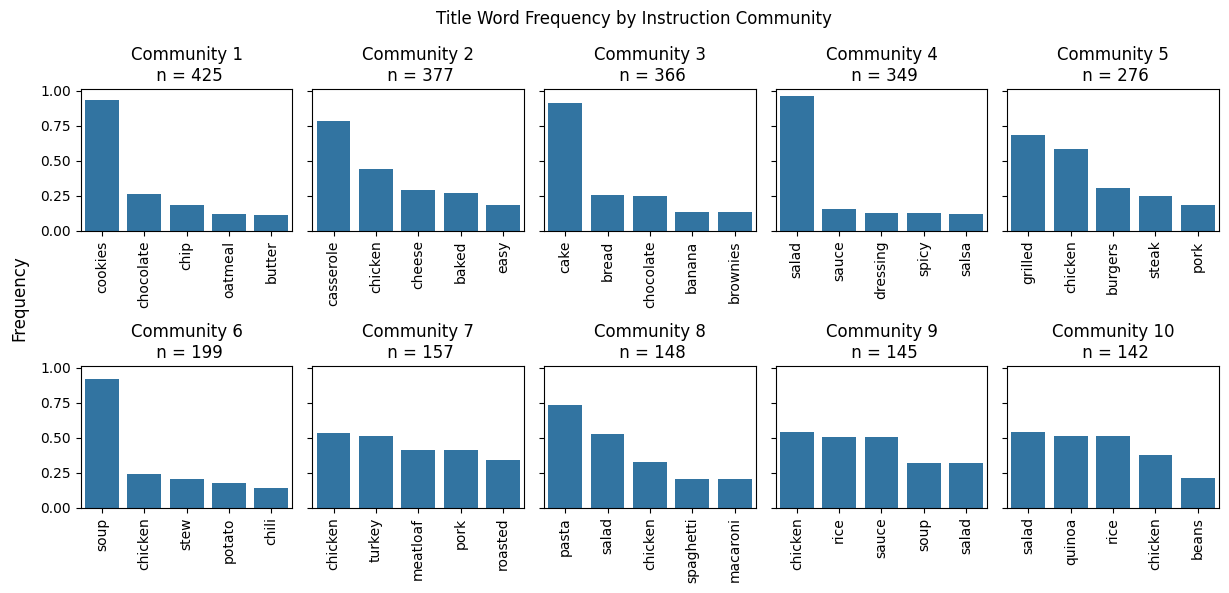

In [60]:
n=10
k=5
def title_dist_for_nodes(nodes, axes):
    dats = datacleaning.data_for_nodes(nodes)
    dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    dats['title_words'] = dats['title_words'].str.lower()
    dats['title_words'] = dats['title_words'].str.split()
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(list(FreqDist(title_words).items()), columns = ["word","frequency"])

    title_freqs['weighted_frequency'] = title_freqs['frequency']
    title_freqs = title_freqs.sort_values(by = 'weighted_frequency', ascending= False).head(5)

    sns.barplot(x=title_freqs['word'], y=title_freqs['weighted_frequency']/np.linalg.norm(title_freqs['weighted_frequency']), ax= axes, errorbar=('ci', 0))
    return title_words

def plot_communities(communities):
    fig, ax = plt.subplots(2,int(n/2), figsize= (12,6), sharey=True)
    i = 1
    plt_i = 0
    plt_j = 0
    for community in communities:
        if len(community) < 100:
            i = i + 1
            continue
        if plt_i + int(n/2)*plt_j >= n:
            break
        if plt_i == int(n/2):
            plt_j = 1
            plt_i = 0
        title_dist_for_nodes(communities[i], ax[plt_j, plt_i])
        ax[plt_j, plt_i].tick_params('x', labelrotation=90)
        ax[plt_j, plt_i].set_title("Community " + str(i) + "\n n = " + str(len(community)))
        ax[plt_j, plt_i].set_ylabel("")
        ax[plt_j, plt_i].set_xlabel("")

        plt_i = plt_i + 1
        i = i + 1
    fig.text(-.02, 0.5, 'Frequency', va='center', rotation='vertical', size='large')
    fig.suptitle("Title Word Frequency by Instruction Community")
    fig.align_xlabels()
    fig.tight_layout()


plot_communities(inst_communities)

plt.savefig('figs/tfidf_instcommunity_titles.pdf')

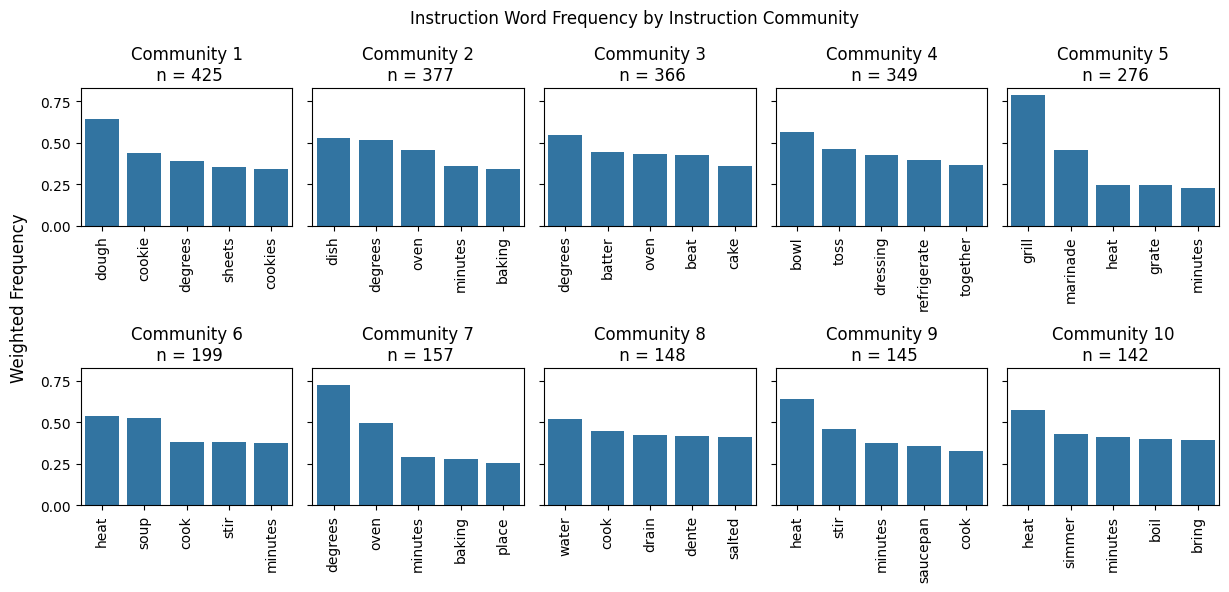

In [57]:
n=10
k=5
def title_dist_for_nodes(nodes, axes, column, weights):
    dats = datacleaning.data_for_nodes(nodes)
    # dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    # dats['title_words'] = dats['title_words'].str.lower()
    # dats['title_words'] = dats['title_words'].str.split()
    dats['title_words'] = dats[column]
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(list(FreqDist(title_words).items()), columns = ["word","frequency"])
    
    title_freqs = title_freqs.merge(weights, on = 'word')

    title_freqs['weighted_frequency'] = title_freqs['frequency'] * title_freqs['weight']
    title_freqs = title_freqs.sort_values(by = 'weighted_frequency', ascending = False).head(5)

    sns.barplot(x=title_freqs['word'], y=title_freqs['weighted_frequency']/np.linalg.norm(title_freqs['weighted_frequency']), ax= axes, errorbar=('ci', 0))
    return title_words

def plot_communities(communities, column, weights, title):
    fig, ax = plt.subplots(2,int(n/2), figsize= (12,6), sharey=True)
    i = 1
    plt_i = 0
    plt_j = 0
    for community in communities:
        if len(community) < 100:
            i = i + 1
            continue
        if plt_i + int(n/2)*plt_j >= n:
            break
        if plt_i == int(n/2):
            plt_j = 1
            plt_i = 0
        title_dist_for_nodes(communities[i], ax[plt_j, plt_i], column, weights)
        ax[plt_j, plt_i].tick_params('x', labelrotation=90)
        ax[plt_j, plt_i].set_title("Community " + str(i) + "\n n = " + str(len(community)))
        ax[plt_j, plt_i].set_ylabel("")
        ax[plt_j, plt_i].set_xlabel("")

        plt_i = plt_i + 1
        i = i + 1
    fig.text(-.02, 0.5, 'Weighted Frequency', va='center', rotation='vertical', size='large')
    fig.suptitle(title)
    fig.align_xlabels()
    fig.tight_layout()

plot_communities(inst_communities,'instruction_words', instructions_idf,title = "Instruction Word Frequency by Instruction Community")

plt.savefig('figs/tfidf_instcommunity_instructions.pdf')

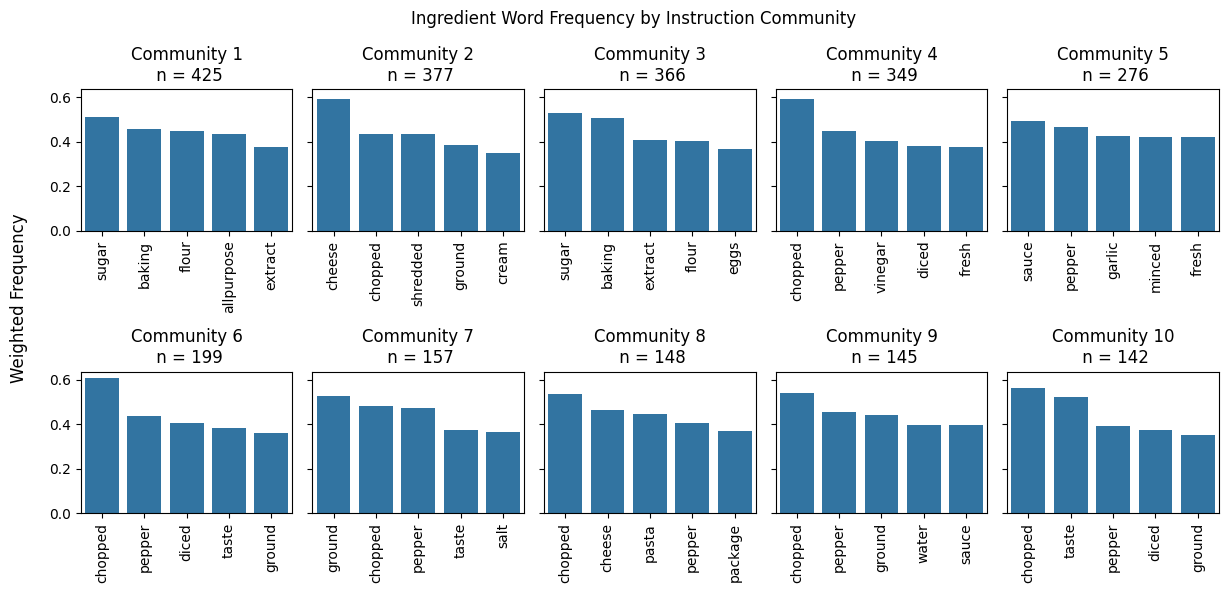

In [58]:
plot_communities(inst_communities,'ingredient_words', ingredients_idf,title = "Ingredient Word Frequency by Instruction Community")
plt.savefig('figs/tfidf_instcommunity_ingredients.pdf')

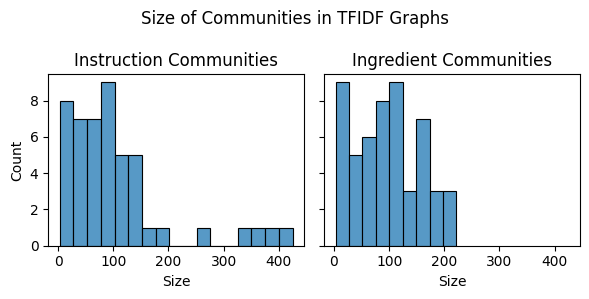

In [54]:
def count_communities(communities):
    coms = sorted(communities, key=len, reverse=True)
    lens = [len(g) for g in coms]
    # s, count = np.unique(np.sort(lens), return_counts=True)
    return lens

def plot_components(data, axes):
    a = sns.histplot(x = data, ax=axes, binwidth=25)

fig, axes = plt.subplots(1,2, figsize= (6,3), sharex=True, sharey=True)
plot_components(count_communities(inst_communities), axes=axes[0])
plot_components(count_communities(ingr_communities), axes=axes[1])
axes[0].set_title("Instruction Communities")
axes[1].set_title("Ingredient Communities")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Size")
axes[1].set_xlabel("Size")
fig.suptitle("Size of Communities in TFIDF Graphs")

fig.tight_layout()
plt.savefig('figs/tfidf_community_sizes.pdf')

In [90]:
instruction_ranked_tfidf_cent.set_index('Id')

,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,ingredients,...,clean_ingredients,clean_instructions,clean_instructions_masked,ingredient_words,instruction_words,index,degree_centrality,pagerank_centrality,betweenness_centrality,sum_idf
Id,,,,,,,,,,,,,,,,,,,,,
5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO,0,0,0,0,0,0,0,0,Southern-Style Chocolate Pound Cake,1 cup butter ADVERTISEMENT 1/2 cup shortening ...,...,butter shortening white sugar eggs vanilla ext...,preheat oven degrees degrees grease flour loaf...,preheat oven degrees degrees grease loaf pans ...,"[butter, shortening, white, sugar, eggs, vanil...","[preheat, oven, degrees, degrees, grease, loaf...",5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO,0.002601,0.000645,0.004911,150.919070
DIzfv.NycIqtwo58y7fteog1dKRw12O,1,1,1,1,1,1,1,1,Pumpkin Pie I,1 egg ADVERTISEMENT 1 tablespoon all-purpose f...,...,egg allpurpose flour white sugar salt pumpkin ...,preheat oven degrees degrees add sugar gradual...,preheat oven degrees degrees add gradually bea...,"[egg, allpurpose, flour, white, sugar, salt, p...","[preheat, oven, degrees, degrees, add, gradual...",DIzfv.NycIqtwo58y7fteog1dKRw12O,0.000600,0.000174,0.001502,119.695606
TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW,2,2,2,2,2,2,2,2,Cinnamon Oatmeal Zucchini Cookies,"1 1/2 cups butter, softened ADVERTISEMENT 1 1/...",...,butter softened white sugar eggs vanilla extra...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheets bea...,"[butter, softened, white, sugar, eggs, vanilla...","[preheat, oven, degrees, degrees, grease, shee...",TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW,0.000400,0.000117,0.000140,155.065822
3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy,3,3,3,3,3,3,3,3,Plum-Oat Drop Biscuits,2 tablespoons white sugar ADVERTISEMENT 1/2 te...,...,white sugar ground cinnamon allpurpose flour r...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheet comb...,"[white, sugar, ground, cinnamon, allpurpose, f...","[preheat, oven, degrees, degrees, grease, shee...",3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy,0.000400,0.000131,0.000000,179.323968
8lZak.EVdLP9/dukyN72DYHyjseFwV2,4,4,4,4,4,4,4,4,Ghirardelli Milk Chocolate Chip Cookies,2 1/4 cups all-purpose flour ADVERTISEMENT 1 t...,...,allpurpose flour baking soda salt unsalted but...,preheat oven degrees stir together flour bakin...,preheat oven degrees stir together set aside b...,"[allpurpose, flour, baking, soda, salt, unsalt...","[preheat, oven, degrees, stir, together, set, ...",8lZak.EVdLP9/dukyN72DYHyjseFwV2,0.000600,0.000181,0.002438,201.304162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O,4995,4995,4995,4995,4995,4995,4995,4995,Sun-Dried Tomato With Fresh Basil Spread,1/2 cup oil-packed sun-dried tomatoes ADVERTIS...,...,oilpacked sundried tomatoes basil leaves ounce...,place sundried tomatoes work bowl food process...,place work bowl food processor pulse coarsely ...,"[oilpacked, sundried, tomatoes, basil, leaves,...","[place, work, bowl, food, processor, pulse, co...",z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O,0.000600,0.000182,0.001918,89.021971
g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K,4996,4996,4996,4996,4996,4996,4996,4996,Banana Split Martini,ice as needed ADVERTISEMENT 2 fluid ounces whi...,...,ice needed fluid ounces white chocolate liqueu...,fill cocktail shaker ice add white chocolate l...,fill cocktail shaker add creme de cover shake ...,"[ice, needed, fluid, ounces, white, chocolate,...","[fill, cocktail, shaker, add, creme, de, cover...",g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K,0.000400,0.000127,0.000000,78.463829
dsDOddsQtDp7xomWY2mQwcoTyLeUfYa,4997,4997,4997,4997,4997,4997,4997,4997,Citrus Glazed Banana Squash,"1 1/2 pounds banana squash, peeled and cubed A...",...,banana squash peeled cubed butter water needed...,melt butter large skillet medium heat add squa...,melt large skillet medium heat add cubes cover...,"[banana, squash, peeled, cubed, butter, wate

In [167]:
i = 1
inst_communities_df = {}
inst_communities_size = {}
com_betweenness = {}
for com in inst_communities:
    inst_communities_df[i] = com
    inst_communities_size[i] = len(com)
    com_data = pd.DataFrame([rec for rec in com]).rename(columns={0: "Id"}).set_index('Id').join(instruction_ranked_tfidf_cent.set_index('Id'))['betweenness_centrality']
    com_betweenness[i] = (sum(com_data)/len(com), max(com_data))
    i = i+1

inst_communities_df = pd.DataFrame(inst_communities_df.items(),columns=['community_num','nodes']).set_index('community_num')


inst_communities_size = pd.DataFrame(inst_communities_size.items(),columns=['community_num','size']).set_index('community_num')

inst_communities_df = inst_communities_df.join(inst_communities_size)
com_betweenness = pd.DataFrame(com_betweenness.items(), columns=['community_num', 'avg_betweenness']).set_index('community_num').sort_values(by='avg_betweenness', ascending = False)
com_betweenness = pd.DataFrame(com_betweenness['avg_betweenness'].tolist(), index=com_betweenness.index).rename(columns = {0:'average',1:'max'})
inst_communities_df = inst_communities_df.join(com_betweenness)

<Axes: xlabel='size', ylabel='average'>

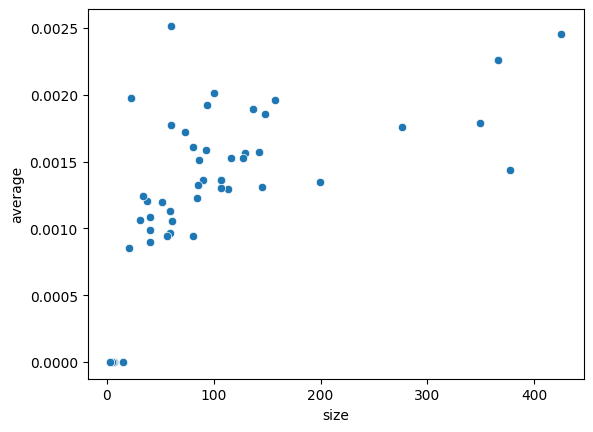

In [173]:
inst_communities_df.sort_values(by='max', ascending=False)

sns.scatterplot(data=inst_communities_df, x='size', y='average')

average    0.002261
max        0.043518
Name: 3, dtype: float64

In [194]:
inst_communities_df.sort_values(by='average', ascending=False)

,nodes,size,average,max
community_num,,,,
30,"{V5lbnb5HXOgw4AkmothEQrD4ic8fjTq, 5dZ49UPpFuN6...",60,2.516186e-03,2.049601e-02
1,"{NedtGQs2JOw87LriBTrXfS28q2/N5a6, BLyEHdxKsQBd...",425,2.454687e-03,7.066136e-02
3,"{fjVtlpM6NqF6PDwUDNHOaeeSbICfEVm, Xjl2OmcbaUdp...",366,2.261385e-03,4.351792e-02
18,"{cqRsCJMFsm90uY1U/AhQP1C1hcSO5S6, 3CgeZjwvNkj3...",100,2.013502e-03,1.539314e-02
41,"{FHTGTNtwL3PuMgXmXbiPWVFp00ffZsC, sgddsOBtRKLe...",23,1.978770e-03,8.696097e-03
7,"{5BTDOJYPdXZX2WfgcW.1X.Ar8I5RIQa, pHI.G7s5LPyO...",157,1.963495e-03,2.711801e-02
19,"{mXzs/aOOsgjpnAiKBfcb0nzhzHY/tAS, wE9K5Ru3Uqbt...",94,1.924452e-03,1.209346e-02
11,"{X8o95CdsNdC0Kcp5cKwo12z1O4K.uPu, TcKxDGFJwUzX...",137,1.895816e-03,3.725008e-02
8,"{3r2KTnb.G8dhf2egL0KL15lcJkEqkwC, LezWCHmjEhDJ...",148,1.854456e-03,1.550308e-02


['lemongarlic',
 'salad',
 'dressing',
 'creamy',
 'clam',
 'taeng',
 'spicy',
 'cucumber',
 'salad',
 'cucumber',
 'favorites',
 'georgia',
 'cracker',
 'salad',
 'refreshing',
 'mango',
 'chutney',
 'mudslide',
 'mousse',
 'shots',
 'best',
 'ever',
 'kabob',
 'marinade',
 'korean',
 'style',
 'salad',
 'dressing',
 'yogurt',
 'granola',
 'tahini',
 'salad',
 'chickpea',
 'salad',
 'onion',
 'tomato',
 'super',
 'easy',
 'artichokes',
 'asparagus',
 'fresh',
 'apple',
 'salsa',
 'pineapple',
 'mustard',
 'sauce',
 'easy',
 'pizza',
 'sauce',
 'mexican',
 'basic',
 'pork',
 'brine',
 'honey',
 'ginger',
 'plum',
 'sundae',
 'selfrising',
 'cornmeal',
 'mayofree',
 'tuna',
 'sandwich',
 'filling',
 'crab',
 'avocado',
 'salad',
 'fruit',
 'salsa',
 'colorful',
 'edible',
 'play',
 'dough',
 'simple',
 'greek',
 'yogurt',
 'salad',
 'citrus',
 'ceviche',
 'peanut',
 'butter',
 'chocolate',
 'waffle',
 'sandwich',
 'avocado',
 'toast',
 'vegan',
 'cabbage',
 'chickpea',
 'salad',
 'avoca

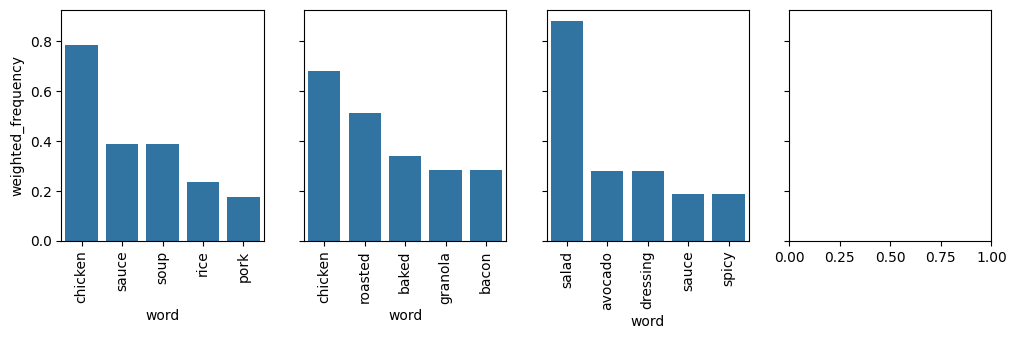

In [202]:

fig, ax = plt.subplots(1,4, figsize= (12,3), sharey=True)

def title_dist_for_nodes(nodes, axes):
    dats = datacleaning.data_for_nodes(nodes)
    dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    dats['title_words'] = dats['title_words'].str.lower()
    dats['title_words'] = dats['title_words'].str.split()
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(list(FreqDist(title_words).items()), columns = ["word","frequency"])

    title_freqs['weighted_frequency'] = title_freqs['frequency']
    title_freqs = title_freqs.sort_values(by = 'weighted_frequency', ascending= False).head(5)

    sns.barplot(x=title_freqs['word'], y=title_freqs['weighted_frequency']/np.linalg.norm(title_freqs['weighted_frequency']), ax= axes, errorbar=('ci', 0))
    axes.tick_params('x', labelrotation=90)
    return title_words


title_dist_for_nodes(inst_communities_df.loc[1]['nodes'], ax[0])
title_dist_for_nodes(inst_communities_df.loc[18]['nodes'], ax[1])
title_dist_for_nodes(inst_communities_df.loc[33]['nodes'], ax[2])

# inst_communities_df.loc[list(com_betweenness.index)[1]]['nodes']

In [203]:
datacleaning.data_for_nodes(inst_communities_df.loc[33]['nodes'])

,title,ingredients,instructions,picture_link,clean_ingredients,clean_instructions,clean_instructions_masked,title_words,ingredient_words,instruction_words
Id,,,,,,,,,,
Lak8bjKvcsx2ysdSi5ioojkhrdkXkZq,Lemon-Garlic Salad Dressing,2 tablespoons extra-virgin olive oil ADVERTISE...,"Whisk olive oil, lemon juice, garlic, lemon ze...",gGVp7t.zyitEjGSGd9POOzfq3eU.ytK,extravirgin olive oil fresh lemon juice small ...,whisk olive oil lemon juice garlic lemon zest ...,whisk together bowl,"[lemongarlic, salad, dressing]","[extravirgin, olive, oil, fresh, lemon, juice,...","[whisk, together, bowl]"
uwQCoR1MZyn5wR7L0.pPhW.8Y/qto8G,Creamy Clam Dip,"1 (6.5 ounce) can minced clams, drained with j...","Mix together the clams, cream cheese, Worceste...",/IUtifm/xIBqQPcKf/BC3I/8IrL7ZNG,minced clams drained juice reserved package cr...,mix together clams cream cheese worcestershire...,mix together evenly combined thin mixture desi...,"[creamy, clam, dip]","[minced, clams, drained, juice, reserved, pack...","[mix, together, evenly, combined, thin, mixtur..."
8pYeCDcV0JfI5TKW4KzJT7uYVJPxqD2,Yam Taeng (Spicy Cucumber Salad),"3 cucumbers - peeled, seeded, and grated ADVER...","Toss the cucumbers, dried shrimp, beans, and t...",qE58a7Z1Au0GXvPO188iHZZVqna9hLa,cucumbers peeled seeded grated crushed dried s...,toss cucumbers dried shrimp beans tomatoes tog...,toss together bowl stir together small bowl po...,"[yam, taeng, spicy, cucumber, salad]","[cucumbers, peeled, seeded, grated, crushed, d...","[toss, together, bowl, stir, together, small, ..."
2Fa2JsWj7lY8QjFRcXxvquLb1.1j7VO,Cucumber Favorites,1 (1 pound) loaf cocktail rye bread ADVERTISEM...,Spread each slice of cocktail bread with mayon...,BLVTFcbefkbNno/ilWaPXFOSSlPeJcu,loaf cocktail rye bread mayonnaise cucumbers t...,spread slice cocktail bread mayonnaise place s...,spread slice place slices cucumber sprinkle,"[cucumber, favorites]","[loaf, cocktail, rye, bread, mayonnaise, cucum...","[spread, slice, place, slices, cucumber, sprin..."
XtBXfzjDBhtvk4GcHk1GpG9bPuRNBmy,Georgia Cracker Salad,1 (4 ounce) packet saltine crackers ADVERTISEM...,Coarsely crumble the saltines into a medium bo...,oMPYN4vpF5eEGPA/HgmBBfSp4Tfd9EK,packet saltine crackers large tomato chopped g...,coarsely crumble saltines medium bowl mix toma...,coarsely crumble saltines medium bowl mix stir...,"[georgia, cracker, salad]","[packet, saltine, crackers, large, tomato, cho...","[coarsely, crumble, saltines, medium, bowl, mi..."
BqfGsVgk7WHPebuzDH3IIRDAo0Vy8Hy,Refreshing Mango Chutney,"1 red onion, chopped ADVERTISEMENT 1 mango - p...","Mix red onion, mango, tomato, and cilantro tog...",qE58a7Z1Au0GXvPO188iHZZVqna9hLa,red onion chopped mango peeled seeded chopped ...,mix red onion mango tomato cilantro together bowl,mix together bowl,"[refreshing, mango, chutney]","[red, onion, chopped, mango, peeled, seeded, c...","[mix, together, bowl]"
fd0l9LIe/edHPTgL3nRGTl98tF4gP8W,Mudslide Mousse Shots,1 tablespoon hot water ADVERTISEMENT 2 teaspoo...,Stir hot water and espresso powder together in...,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,hot water instant espresso powder skim milk pa...,stir hot water espresso powder together small ...,stir together small bowl dissolved cool room t...,"[mudslide, mousse, shots]","[hot, water, instant, espresso, powder, skim, ...","[stir, together, small, bowl, dissolved, cool,..."
3wzVv1X6HjgIShD5L9GKsL1ug4SvAPi,Best Ever Kabob Marinade,1/2 cup honey ADVERTISEMENT 1/2 cup soy sauce ...,"Whisk honey, soy sauce, chili sauce, cumin, an...",7XARonIu.15xy1hEAPP27IbgbVA83Mu,honey soy sauce tomatobased chili sauce ground...,whisk honey soy sauce chili sauce cumin vegeta...,whisk together bowl,"[best, ever, kabob, marinade]","[honey, soy, sauce, tomatobased, chili, sauce,...","[whisk, together, bowl]"
uzWv4I9UlMVvMiqxgpYrEZQsPCzMJsm,Korean Style Salad Dressing,1/4 cup low-sodium soy sauce ADVERTISEMENT 2 t...,"Whisk soy sauce, sugar, water, rice vinegar, s...",wy6YzCqRurP0BjgWFHdBQFQdsRQHDli,lowsodium soy sauce white sug

In [205]:
i = 1
thing = {}
for com in inst_communities:
    thing.update({movie:i for movie in com})
    i = i+1

nx.set_node_attributes(graph_recipe_instruction_ranked_tfidf, thing, "class")

In [208]:
G_mm = graph_recipe_instruction_ranked_tfidf

merged_G_mm = nx.Graph()
added_nodes = {}
for node, data in G_mm.nodes(data = True):
    if data["class"] not in added_nodes:
        new_node = data["class"]
        added_nodes[data["class"]] = new_node
        merged_G_mm.add_node(new_node, internal_edges = 0)
    else:   
        new_node = added_nodes[data["class"]]
    neighbors = nx.all_neighbors(G_mm, node)
    for neighbor in neighbors:
        if (G_mm.nodes[neighbor]["class"]) == new_node:
            updated_internal_edges = merged_G_mm.nodes[data["class"]].get("internal_edges") + (G_mm.get_edge_data(node, neighbor)).get("weight")
            nx.set_node_attributes(merged_G_mm, {data["class"]: updated_internal_edges},"internal_edges" )

        elif merged_G_mm.get_edge_data(G_mm.nodes[neighbor]["class"], new_node) == None:
            merged_G_mm.add_edge(G_mm.nodes[neighbor]["class"], new_node)
            nx.set_edge_attributes(merged_G_mm, {(G_mm.nodes[neighbor]["class"],new_node):{"weight": (G_mm.get_edge_data(node, neighbor)).get("weight")}})

        elif merged_G_mm.get_edge_data(G_mm.nodes[neighbor]["class"], new_node) != None:
            updated_edge_weight = merged_G_mm.get_edge_data(G_mm.nodes[neighbor]["class"], new_node).get("weight") + (G_mm.get_edge_data(node, neighbor)).get("weight")
            nx.set_edge_attributes(merged_G_mm, {(G_mm.nodes[neighbor]["class"], new_node) : {"weight" : updated_edge_weight}})


In [213]:
nx.write_gexf(merged_G_mm, "com_recipe_instruction_ranked_tfidf.gexf")